In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
from timeit import default_timer as timer
import torch
from torch.autograd import Variable

import numpy as np
from sklearn import manifold
import scipy.sparse as sp
import pickle

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

cuda not available


In [2]:
from core.DimReduction import DimReduction
from core.GraphConvNet2 import GraphConvNet2
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.draw_random_subset import draw_random_subset

cuda not available


In [3]:
dim_reduction = DimReduction(n_components=2)

In [4]:
task_parameters = {}
task_parameters['flag_task'] = 'clustering'
task_parameters['reduction_method'] = 'spectral'

net_parameters = {}
net_parameters['D'] = 784
net_parameters['n_components'] = 2
net_parameters['H'] = 50
net_parameters['L'] = 10

In [5]:
net = GraphConvNet2(net_parameters, task_parameters)
print(net)


nb of hidden layers= 10
dim of layers (w/ embed dim)= [784, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


GraphConvNet2(
  (gnn_cells): ModuleList(
    (0): GraphConvNetcell(
      (Ui1): Linear(in_features=784, out_features=50, bias=False)
      (Uj1): Linear(in_features=784, out_features=50, bias=False)
      (Vi1): Linear(in_features=784, out_features=50, bias=False)
      (Vj1): Linear(in_features=784, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=784, out_features=50, bias=False)
    )
    (1): GraphConvNetcell(
      (Ui1): Linear(i

In [6]:
class graph_block(object):
    def __init__(self, X, y, labels, W, E_start, E_end):
        self.signal = X
        self.target = y
        self.labels = labels
        self.adj_matrix = W
        self.edge_to_starting_vertex = E_start
        self.edge_to_ending_vertex = E_end
        self.time_to_compute = 0
    
    def set_time_to_compute(self, timestamp):
        self.time_to_compute = timestamp

In [7]:
def get_graph_block(X, labels, reduction_method):
    # Affinity matrix
    embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
    W = embedder._get_affinity_matrix(X)
    W = sp.coo_matrix(W)
    
    if reduction_method == 'spectral':
        pass
    elif reduction_method == 'tsne':
        embedder = manifold.TSNE(n_components=2, init='pca', random_state=0)
    
    # Perform dimensionality reduction
    start = timer()
    y = embedder.fit_transform(X)
    end = timer()
    
    # Extract edge information
    nb_edges = W.nnz
    nb_vertices = W.shape[0]
    edge_to_starting_vertex = sp.coo_matrix((np.ones(nb_edges) ,(np.arange(nb_edges), W.row)),
                                            shape=(nb_edges, nb_vertices))
    edge_to_ending_vertex = sp.coo_matrix((np.ones(nb_edges) ,(np.arange(nb_edges), W.col)),
                                          shape=(nb_edges, nb_vertices))
    
    G = graph_block(X, y, labels, W, edge_to_starting_vertex, edge_to_ending_vertex)
    G.set_time_to_compute(end - start)
    return G

In [8]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 5000   
opt_parameters['batch_iters'] = 100

if 1==1: # fast debugging
    opt_parameters['max_iters'] = 100 
    opt_parameters['batch_iters'] = 10
opt_parameters['decay_rate'] = 1.25   

In [9]:
# Load Mnist dataset
data_dir = 'data/mnist'
train_data = get_train_set(data_dir)
test_data = get_test_set(data_dir)

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [11]:
# Initialise train_loader based on batch size
batch_size = 200

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=2, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True,
                                          num_workers=2, pin_memory=False)

In [12]:
# Optimization parameters
max_samples = 6000
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']

# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 

# Statistics
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0
    
for iteration in range(0, max_iters):
    for batch_idx, (inputs, labels) in enumerate(train_loader, start=1):
        if batch_idx * batch_size > max_samples: break

        X_train = inputs.view(inputs.shape[0], -1)
        X_train = X_train.numpy()
        G = get_graph_block(X_train, labels, task_parameters['reduction_method'])

        # Forward pass
        y_pred = net.forward(G)
        
        y_true = G.target
        y_true = Variable( torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 
        
        # Compute L2 loss
        loss = net.loss(y_pred, y_true)
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:

        # time
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        if 1==1:
            print('\niteration= %d, loss(%diter)= %.3f, lr= %.8f, time(%diter)= %.2f' % 
                  (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(10iter)= 0.174, lr= 0.00075000, time(10iter)= 11.59

iteration= 10, loss(10iter)= 0.074, lr= 0.00075000, time(10iter)= 122.26

iteration= 20, loss(10iter)= 0.038, lr= 0.00075000, time(10iter)= 120.35

iteration= 30, loss(10iter)= 0.015, lr= 0.00075000, time(10iter)= 111.97


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a16ec0358>>
Traceback (most recent call last):
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/torch/lib/libshm/core.cpp:99



iteration= 40, loss(10iter)= 0.024, lr= 0.00060000, time(10iter)= 111.08


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x102d3e7f0>>
Traceback (most recent call last):
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/torch/lib/libshm/core.cpp:99



iteration= 50, loss(10iter)= 0.006, lr= 0.00060000, time(10iter)= 111.22

iteration= 60, loss(10iter)= 0.003, lr= 0.00060000, time(10iter)= 112.78


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x11491c710>>
Traceback (most recent call last):
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/torch/lib/libshm/core.cpp:99



iteration= 70, loss(10iter)= 0.004, lr= 0.00048000, time(10iter)= 119.93

iteration= 80, loss(10iter)= 0.003, lr= 0.00048000, time(10iter)= 121.56

iteration= 90, loss(10iter)= 0.002, lr= 0.00048000, time(10iter)= 122.04


In [20]:
inputs, labels = draw_random_subset(train_data, num_samples=200)
inputs = inputs.view(inputs.shape[0],-1)
inputs = inputs.numpy()
G = get_graph_block(inputs, labels, task_parameters['reduction_method'])
y_pred = net.forward(G)
y_pred = y_pred.detach().numpy()

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


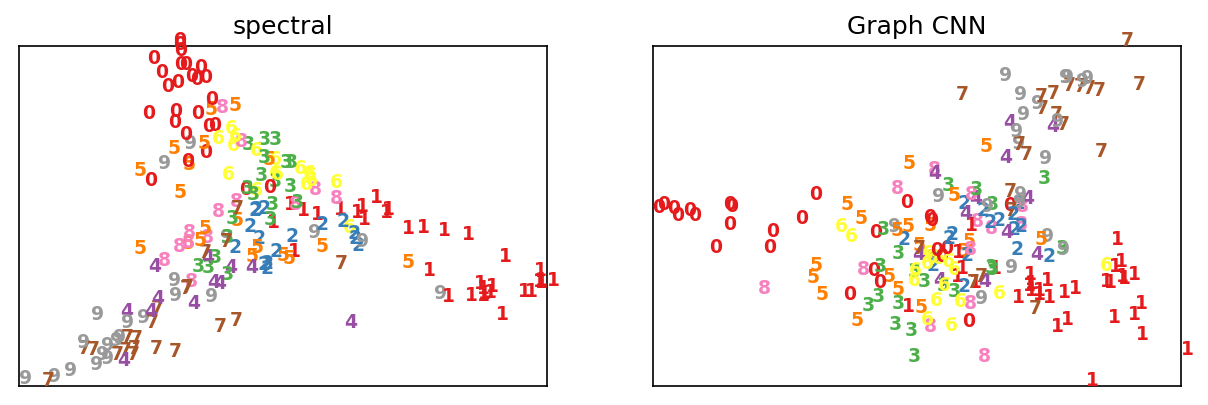

In [21]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), task_parameters['reduction_method'])
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

## On test data

In [40]:
inputs, labels = draw_random_subset(test_data, num_samples=300)
inputs = inputs.view(inputs.shape[0],-1)
inputs = inputs.numpy()
G = get_graph_block(inputs, labels, task_parameters['reduction_method'])
net_time_start = timer()
y_pred = net.forward(G)
net_time_end = timer()
y_pred = y_pred.detach().numpy()

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


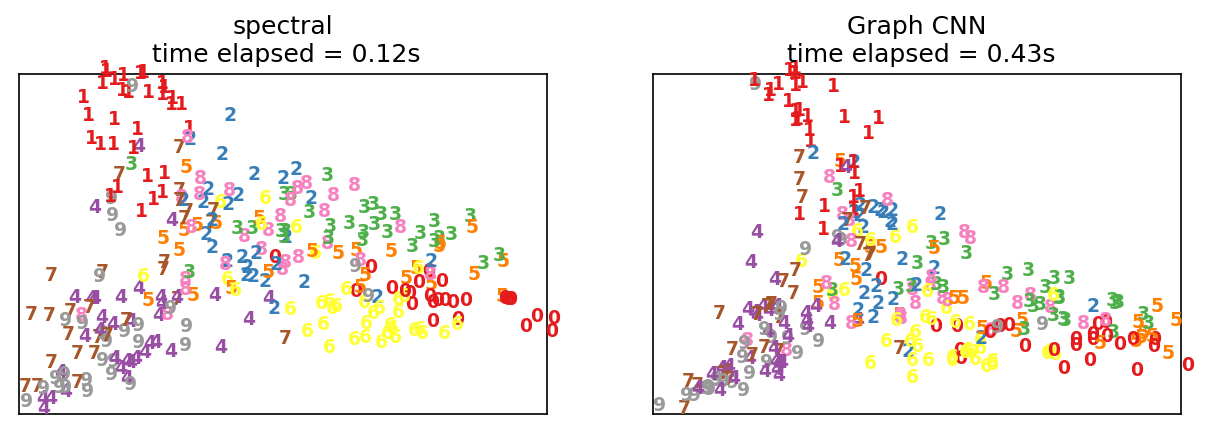

In [41]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
reduction_title = task_parameters['reduction_method'] + "\n time elapsed = {:.2f}s".format(G.time_to_compute) 
cnn_title = "Graph CNN" + "\n time elapsed = {:.2f}s".format(net_time_end - net_time_start) 
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), reduction_title)
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), cnn_title)

In [34]:
filename = 'results/mnist_net2.pkl'
def save_checkpoint(state, filename):
    torch.save(state, filename)
    
save_checkpoint({
    'state_dict': net.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, filename)

In [42]:
filename = 'results/embeddings2.pkl'
with open(filename, 'wb') as f:
    data = pickle.dump([G, y_pred], f)